# **CycleGan day to night**


---


Dana Tartakovsky


---


[Unpaired Day and Night cityview images](https://www.kaggle.com/datasets/heonh0/daynight-cityview)



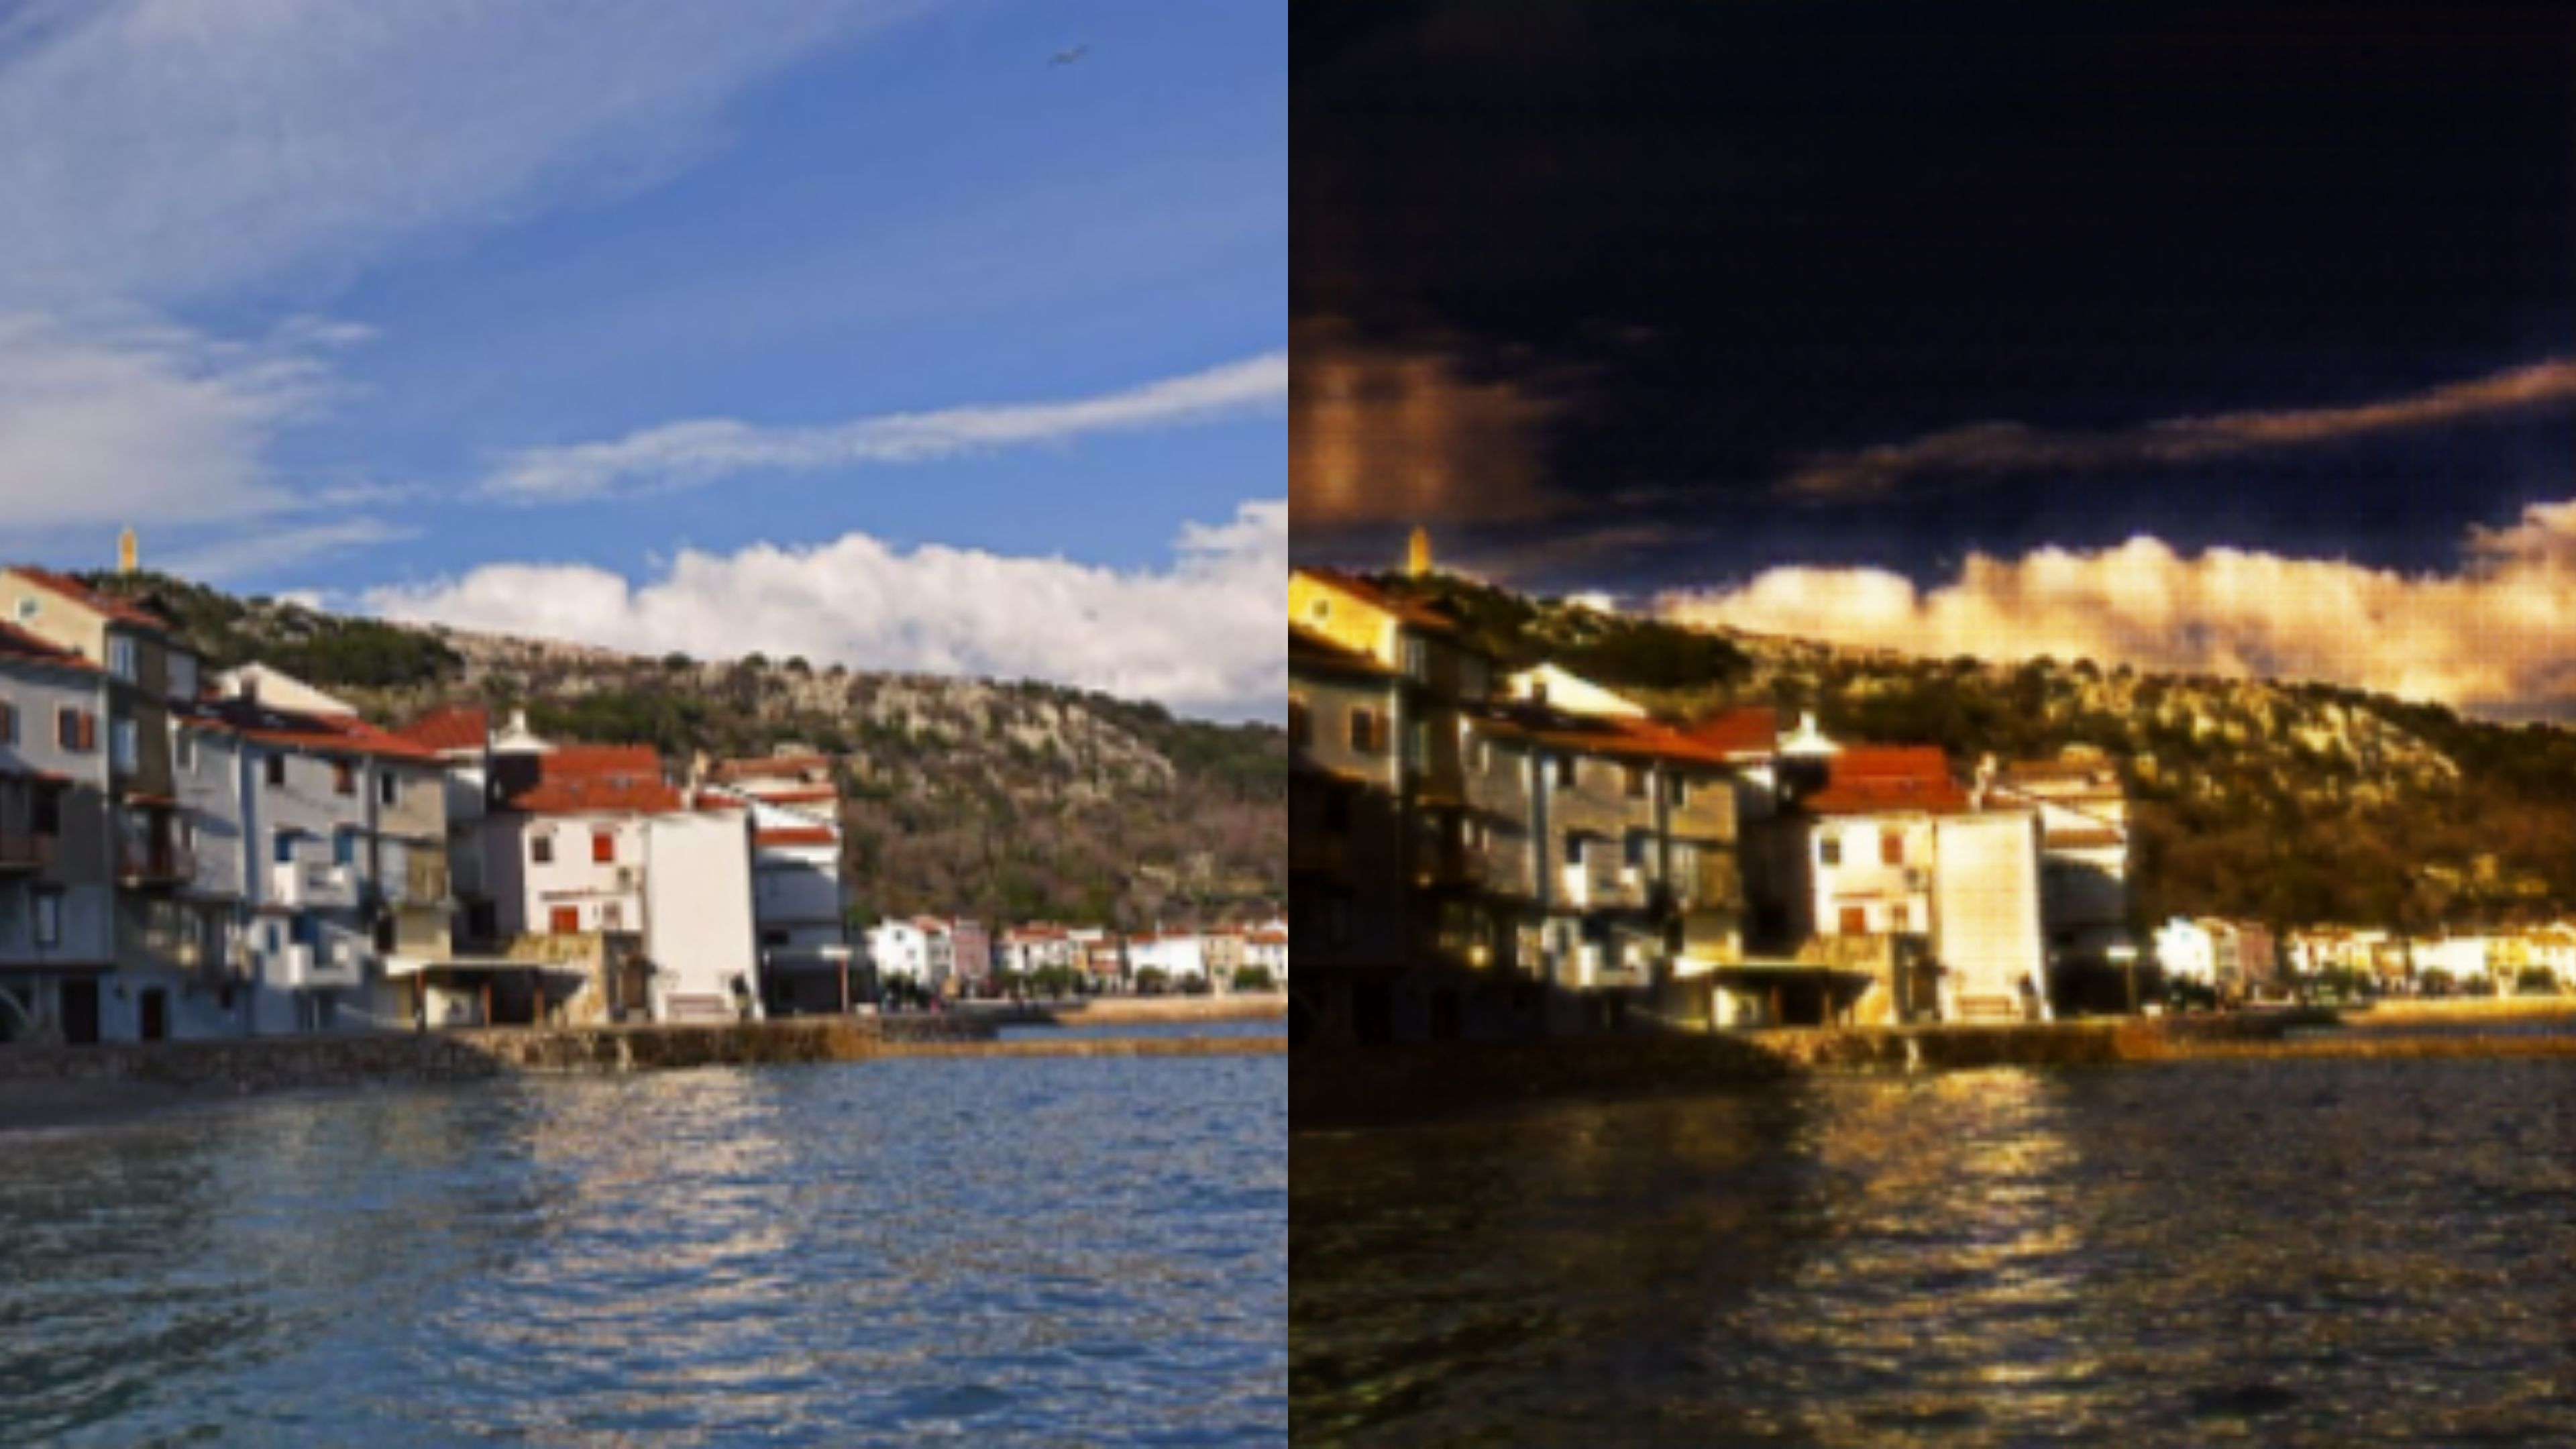

[**סרטון יישום**](https://www.youtube.com/watch?v=B4Quf4fjkIo&list=PLNLf5_3sUeLzRwGG-tJba3reUGPOIqtTG&index=6)

[**קישור לאתר**](https://starry-beautiful-cost.anvil.app/)

# importing libraries

In [ ]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import image as mpimg
import seaborn as sns
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from PIL import Image
from glob import glob
import random
from keras.applications.vgg16 import preprocess_input
import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.layers import Layer, Dense, Reshape, Softmax

In [ ]:
img_width = 512
img_height = 512
batch_size = 1

# Preprocessing functions

In [ ]:
def load_image(image_file):
    '''load a image file'''
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

In [ ]:
def random_crop(img):
  img = tf.squeeze(img)
  img_crop = tf.image.random_crop(img, size=[img_height, img_width, 3])
  return img_crop

In [ ]:
#התמונות כבר מנורמלות מ0 ל1 עם כמה ערכים שיוצאים מהטווח ולכן עושים clipping
def normalize(img):
  img = tf.cast(img, tf.float32)
  img = tf.clip_by_value(img, 0, 1)
  return img

In [ ]:
#preprocessing to prevent overfit
def random_jitter(img):
  img = tf.image.resize(img, [900, 900], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  img = random_crop(img)
  img = tf.image.random_flip_left_right(img)
  return img

In [ ]:
def process_training_img(img):
  img = random_jitter(img)
  img = normalize(img)
  return img

In [ ]:
def process_testing_img(img):
  img = normalize(img)
  return img

# Importing and visualizing data

In [ ]:
#dataset downloading
!kaggle datasets download heonh0/daynight-cityview

Dataset URL: https://www.kaggle.com/datasets/heonh0/daynight-cityview
License(s): CC0-1.0
 99% 495M/499M [00:05<00:00, 78.4MB/s]
100% 499M/499M [00:05<00:00, 95.7MB/s]


In [ ]:
!unzip -oq daynight-cityview.zip

In [ ]:
day_dir = '/content/day'
night_dir = '/content/night'

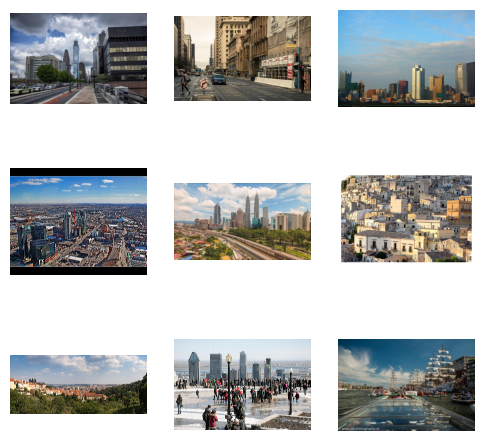

In [ ]:
plt.figure(figsize=(6, 6))
for i, filename in enumerate(os.listdir(day_dir)):
    if i == 9:
        break

    # Construct the full image path
    img_path = os.path.join(day_dir, filename)

    # Open and display the image using PIL
    img = Image.open(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')

In [ ]:
#dataset making
image_paths = tf.io.gfile.glob(os.path.join(day_dir, '*.jpg'))
image_paths = [path for path in image_paths if tf.io.gfile.exists(path)]

day_dataset = tf.data.Dataset.from_tensor_slices(image_paths)

def load_image(image_path):
  image_path = tf.py_function(lambda x: x.numpy().decode('utf-8'), [image_path], tf.string)
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [img_width, img_height])
  return image

day_dataset = day_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
day_dataset=day_dataset.batch(1)

In [ ]:
image_paths = tf.io.gfile.glob(os.path.join(night_dir, '*.jpg'))
image_paths = [path for path in image_paths if tf.io.gfile.exists(path)]

night_dataset = tf.data.Dataset.from_tensor_slices(image_paths)


print(f"Number of images in night_dataset: {len(list(night_dataset.as_numpy_iterator()))}")

night_dataset = night_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
night_dataset=night_dataset.batch(1)

Number of images in night_dataset: 227


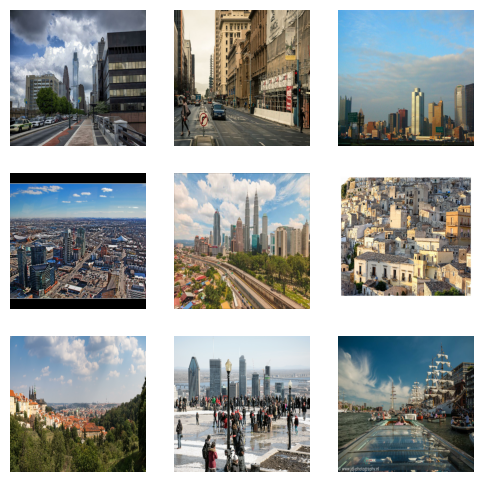

In [ ]:
plt.figure(figsize = (6,6))
for i,xx in enumerate(day_dataset):
  plt.subplot(3, 3, i + 1)
  plt.imshow(xx[0])
  plt.axis('off')
  if i==8:
    break
plt.show()

# Splitting the data

In [ ]:
day_train_batches = tf.data.experimental.cardinality(day_dataset)
day_train_batches.numpy()

522

In [ ]:
night_train_batches = tf.data.experimental.cardinality(night_dataset)
night_train_batches.numpy()

227

In [ ]:
day_test_dataset = day_dataset.take(day_train_batches // 5) #20% for test
day_train_dataset = day_dataset.skip(day_train_batches // 5) #rest for validation
night_test_dataset = night_dataset.take(night_train_batches // 5) #20% for test
night_train_dataset = night_dataset.skip(night_train_batches // 5) #rest for validation

In [ ]:
day_train_batches = tf.data.experimental.cardinality(day_train_dataset)
day_train_batches.numpy()

418

In [ ]:
night_train_batches = tf.data.experimental.cardinality(night_train_dataset)
night_train_batches.numpy()

182

In [ ]:
day_test_batches = tf.data.experimental.cardinality(day_test_dataset)
day_test_batches.numpy()

104

In [ ]:
night_test_batches = tf.data.experimental.cardinality(night_test_dataset)
night_test_batches.numpy()

45

# Data preperation

In [ ]:
day_train_batches = tf.squeeze(day_train_batches)
night_train_batches = tf.squeeze(night_train_batches)
day_test_batches = tf.squeeze(day_test_batches)
night_test_batches = tf.squeeze(night_test_batches)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
#Running the preproccesing functions and doing batching and prefetching
day_train_dataset = day_train_dataset.map(process_training_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
day_test_dataset = day_test_dataset.map(process_testing_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
night_train_dataset = night_train_dataset.map(process_training_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
night_test_dataset = night_test_dataset.map(process_testing_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
type(day_train_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [ ]:
sample_day = next(iter(day_train_dataset))
sample_night = next(iter(night_train_dataset))

In [ ]:
sample_day.shape

TensorShape([1, 512, 512, 3])

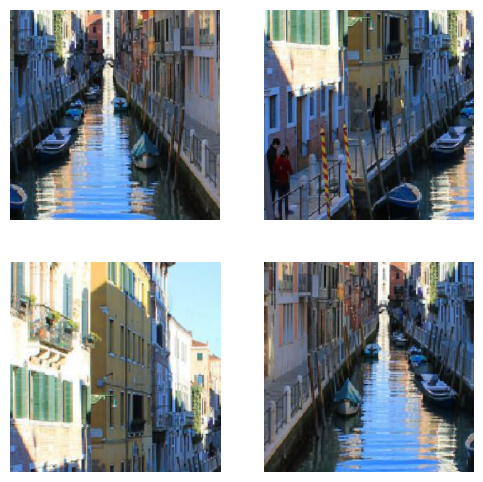

In [ ]:
#Showing the day dataset
plt.figure(figsize = (6,6))
for i in range(4):
  day_jitter = random_jitter(sample_day[0])
  day_jitter = day_jitter.numpy()
  day_jitter = day_jitter[:,:,:3]
  plt.subplot(2, 2, i + 1)
  plt.imshow(day_jitter)
  plt.axis('off')
plt.show()

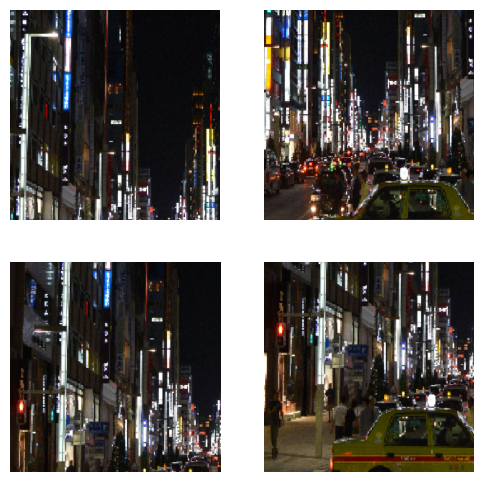

In [ ]:
#Showing the night dataset
plt.figure(figsize = (6,6))
for i in range(4):
  night_jitter = random_jitter(sample_night[0])
  plt.subplot(2, 2, i + 1)
  plt.imshow(night_jitter)
  plt.axis('off')
plt.show()

# Generator and Discriminator

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
    """
    Instance Normalization Layer.

    This layer applies instance normalization to the input, normalizing
    activations within each image individually. This is often used in
    image-to-image translation tasks.
    """

    def __init__(self, epsilon=1e-5):
        """
        Initializes the InstanceNormalization layer.

        Args:
            epsilon: A small value added to the variance to avoid division by zero.
        """
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
      #Builds the layer by creating the learnable parameters (scale and offset).
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)

        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        #Applies instance normalization to the input
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [ ]:
def downsample(filters, size, norm_type = 'batchnorm', apply_norm=True):
  #Downsamples an input image using convolutional layers.
  initializer = tf.random_normal_initializer(0., 0.02) # Initialize weights with a normal distribution
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    else:
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
#Upsamples an input image using transposed convolutional layers.
def upsample(filters, size, norm_type = 'batchnorm', apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
#Creates a U-Net generator model.
def unet_generator(output_channels, norm_type = 'batchnorm'):

  down_stack = [ # Define the downsampling path (encoder)
      downsample(64, 4, norm_type, apply_norm=False),
      downsample(128, 4, norm_type),
      downsample(256, 4, norm_type),
      downsample(512, 4, norm_type),
      downsample(512, 4, norm_type),
      downsample(512, 4, norm_type),
      downsample(512, 4, norm_type),
      downsample(512, 4, norm_type)
  ]

  up_sample = [ # Define the upsampling path (decoder)
      upsample(512, 4, norm_type, apply_dropout=True),
      upsample(512, 4, norm_type, apply_dropout=True),
      upsample(512, 4, norm_type, apply_dropout=True),
      upsample(512, 4, norm_type),
      upsample(256, 4, norm_type),
      upsample(128, 4, norm_type),
      upsample(64, 4, norm_type)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') # Add the final transposed convolutional layer

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[img_height, img_width, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1]) # Reverse the skips for the upsampling path

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_sample, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x) # Apply the final layer

  return tf.keras.Model(inputs=inputs, outputs=x)


In [ ]:
#Creates a discriminator model with a selectable normalization type.
def discriminator(norm_type = 'batchnorm'):
  initializer = tf.random_normal_initializer(0.,0.02)

  inp = tf.keras.layers.Input(shape=[img_height, img_width, 3], name = 'input_image')
  x = inp
  # Downsampling through the model
  down1 = downsample(64, 4, norm_type, False)(x)
  down2 = downsample(128, 4, norm_type)(down1)
  down3 = downsample(256, 4, norm_type)(down2)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

  # Apply normalization based on the selected type
  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

  return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
output_channels = 3 # Define the number of output channels for the generators (RGB images have 3 channels)
generator_g = unet_generator(output_channels, norm_type = 'instancenorm')
generator_f = unet_generator(output_channels, norm_type = 'instancenorm')
discriminator_x = discriminator(norm_type = 'instancenorm')
discriminator_y = discriminator(norm_type = 'instancenorm')

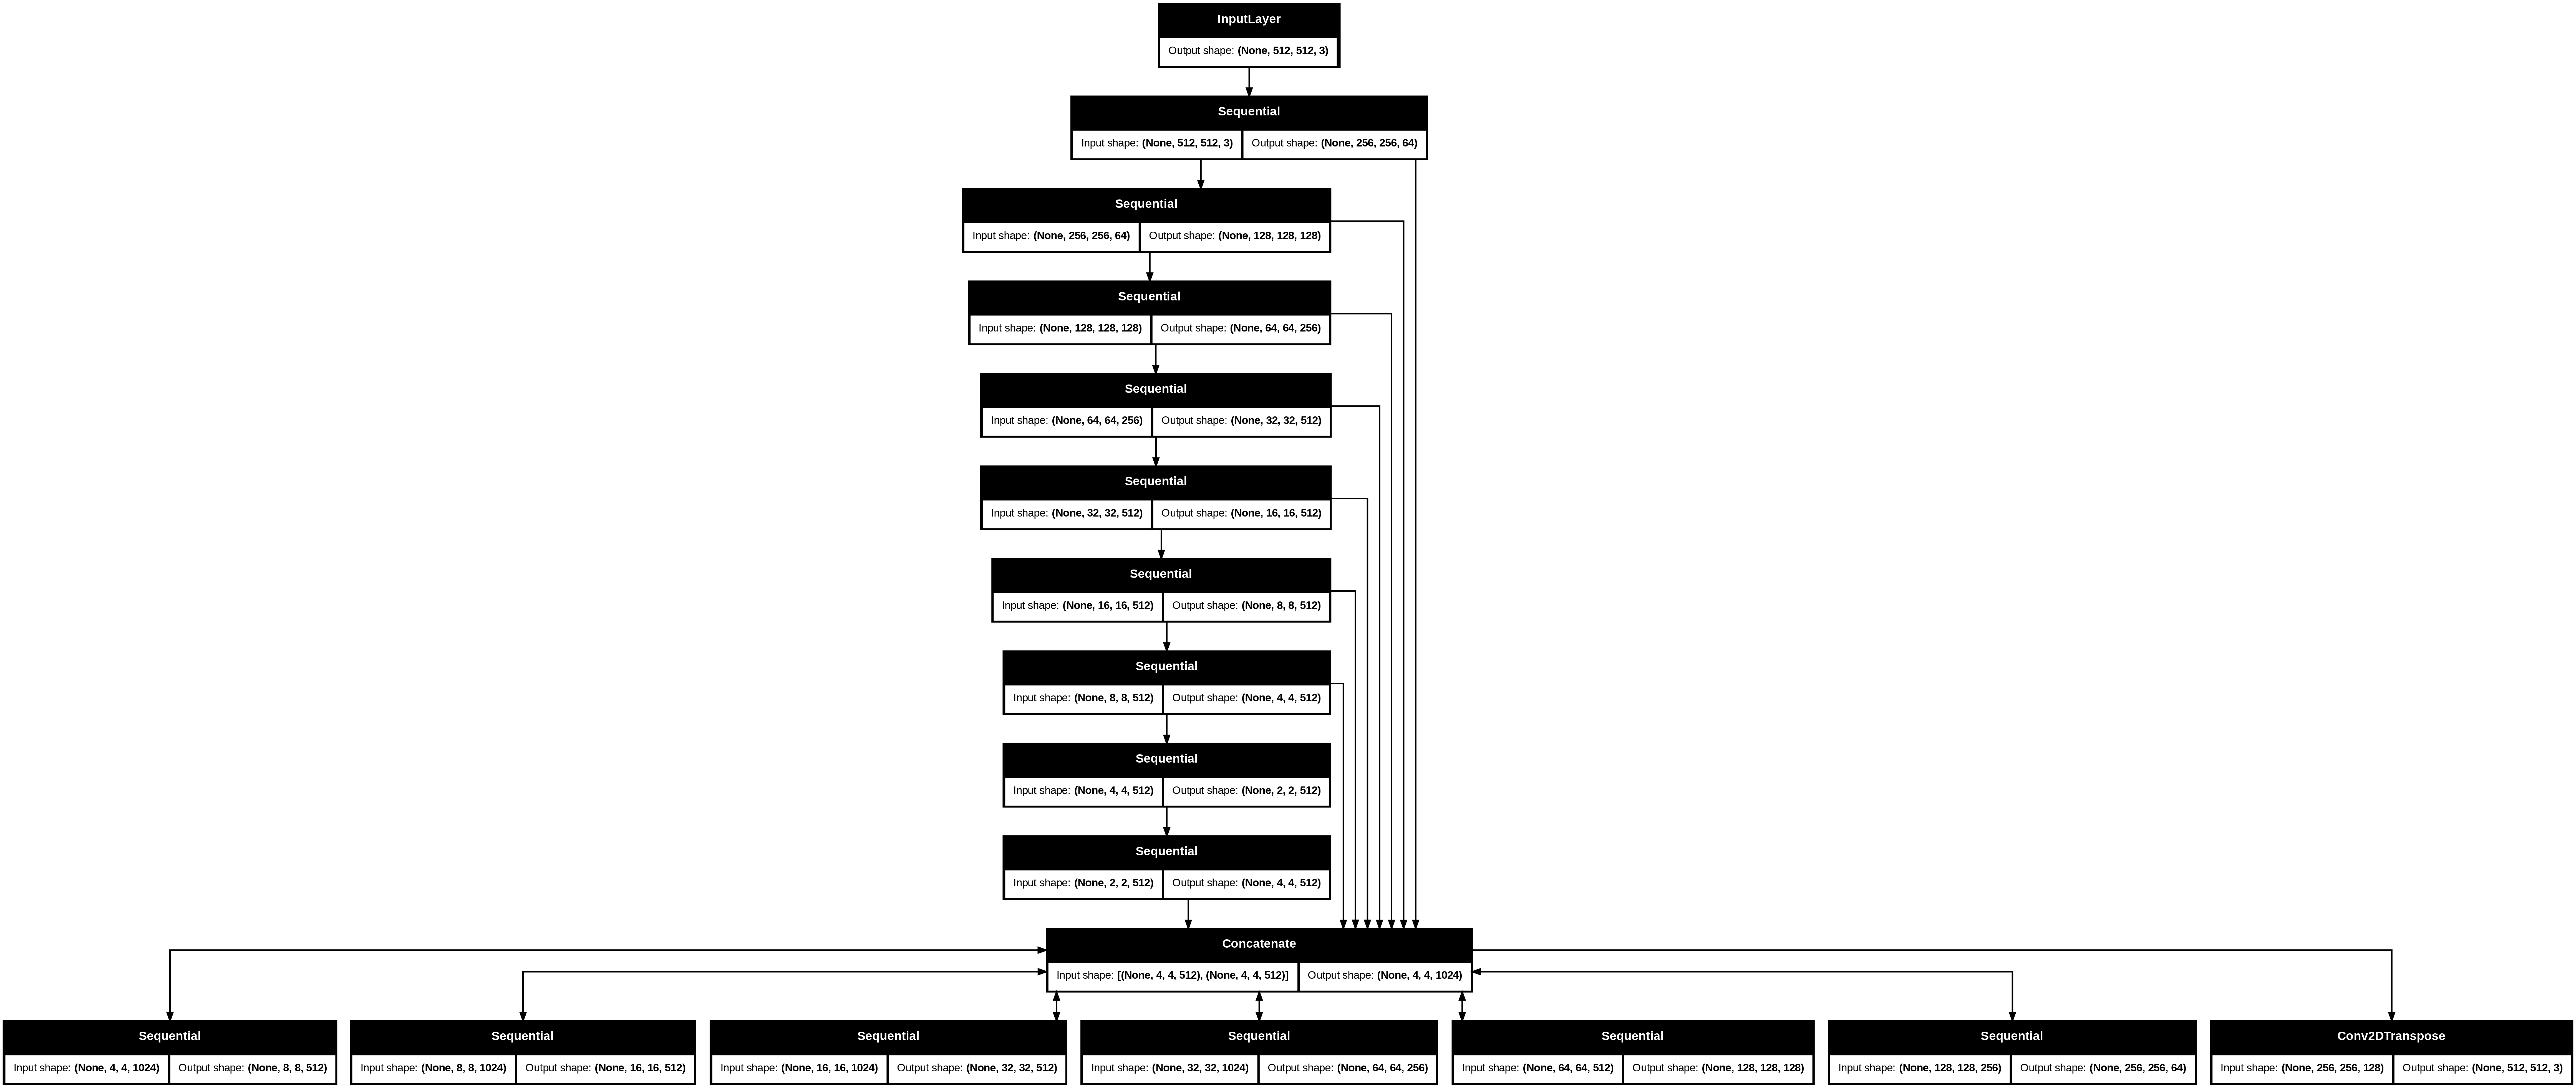

In [ ]:
tf.keras.utils.plot_model(generator_g, show_shapes=True)

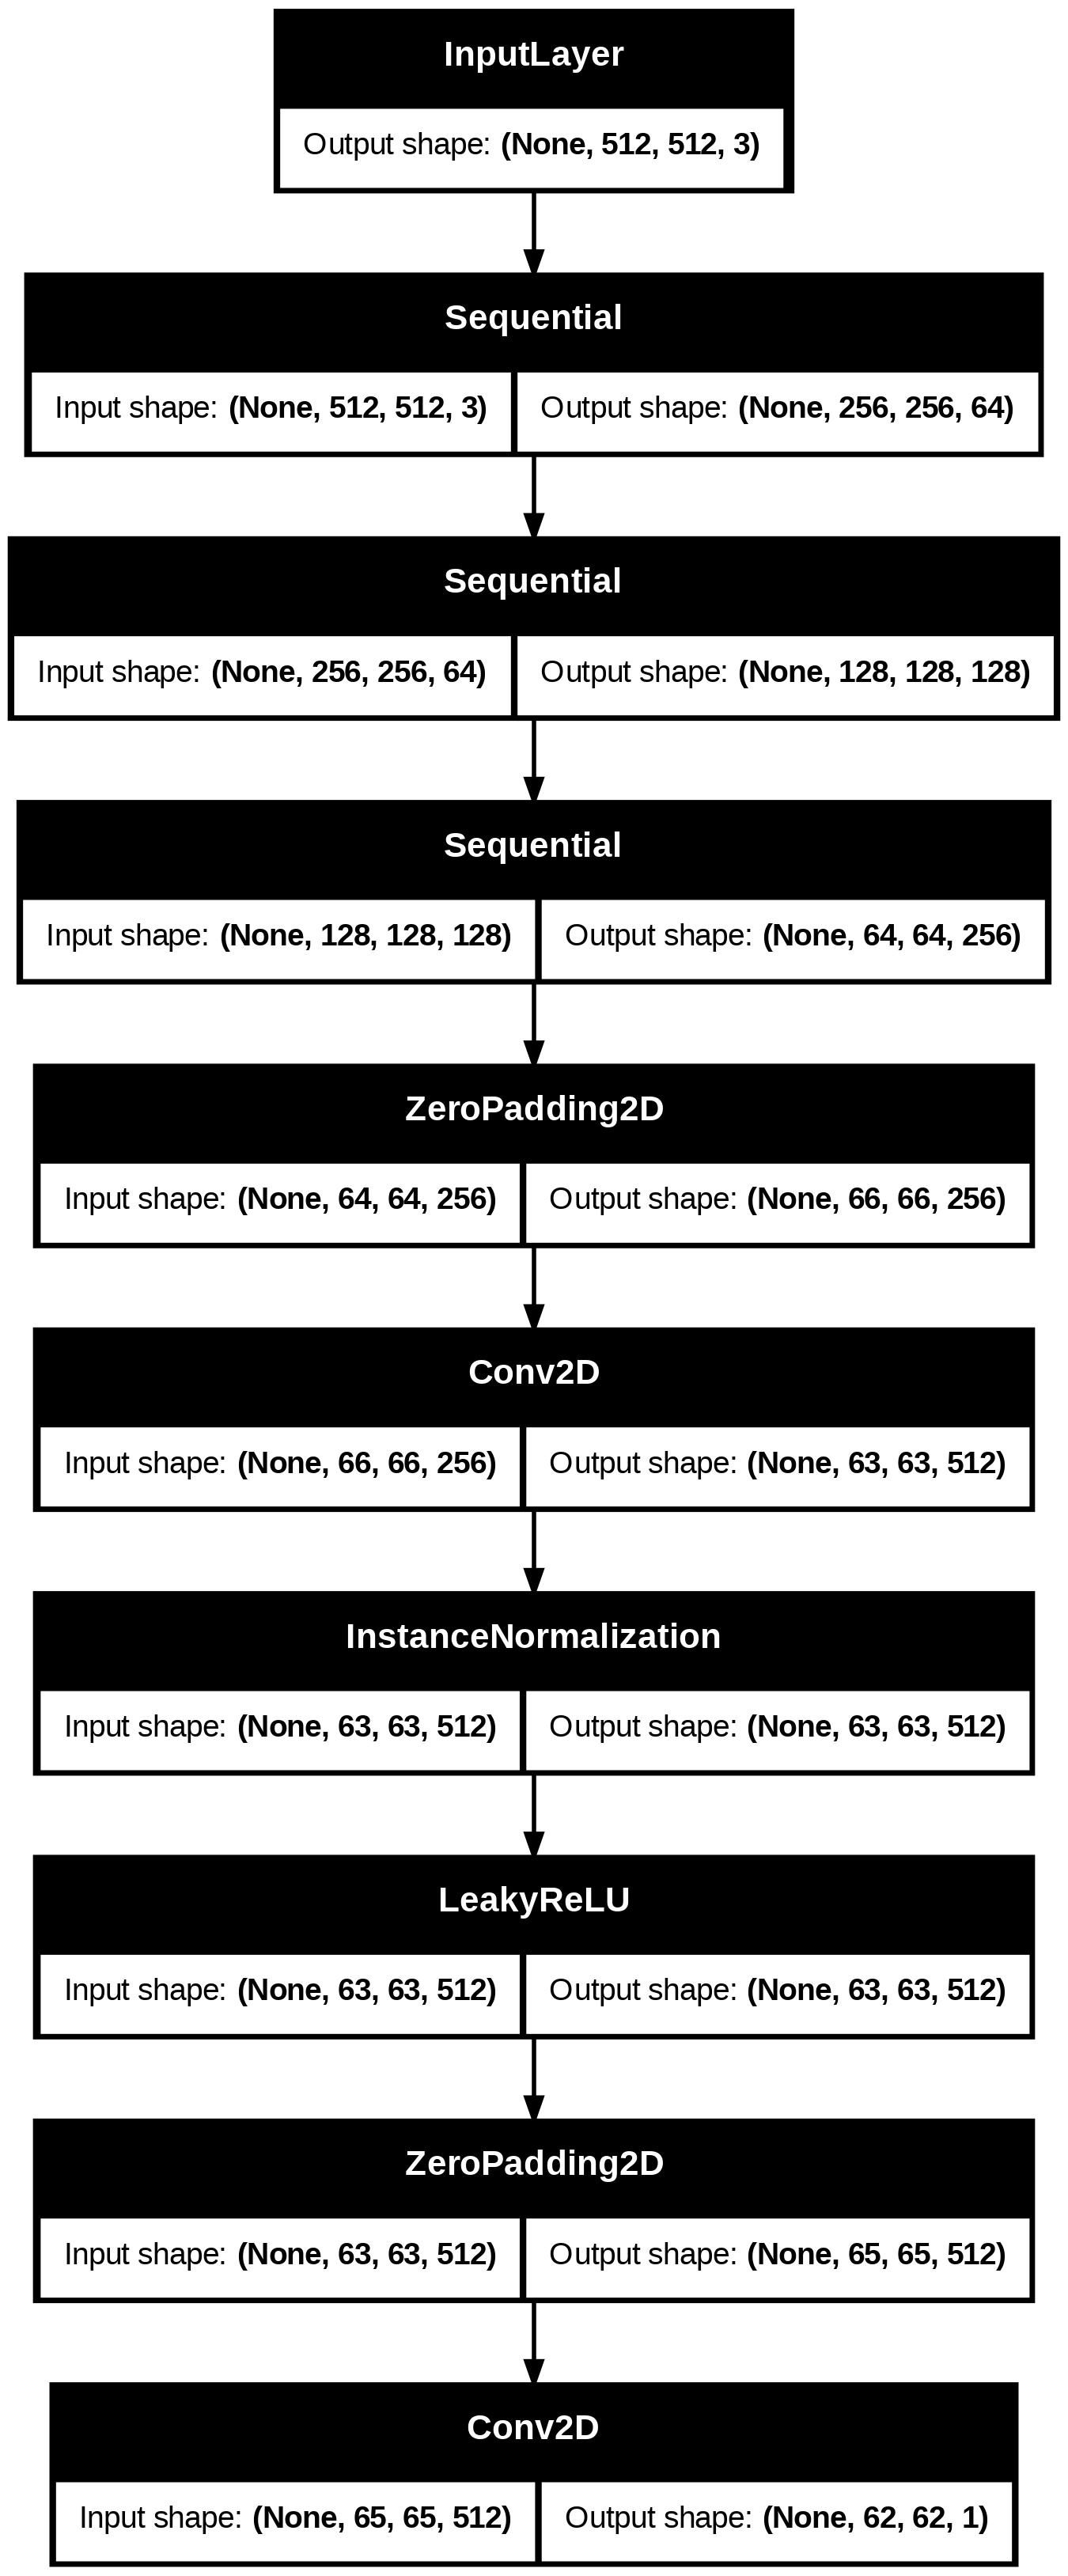

In [ ]:
tf.keras.utils.plot_model(discriminator_x,show_shapes=True)

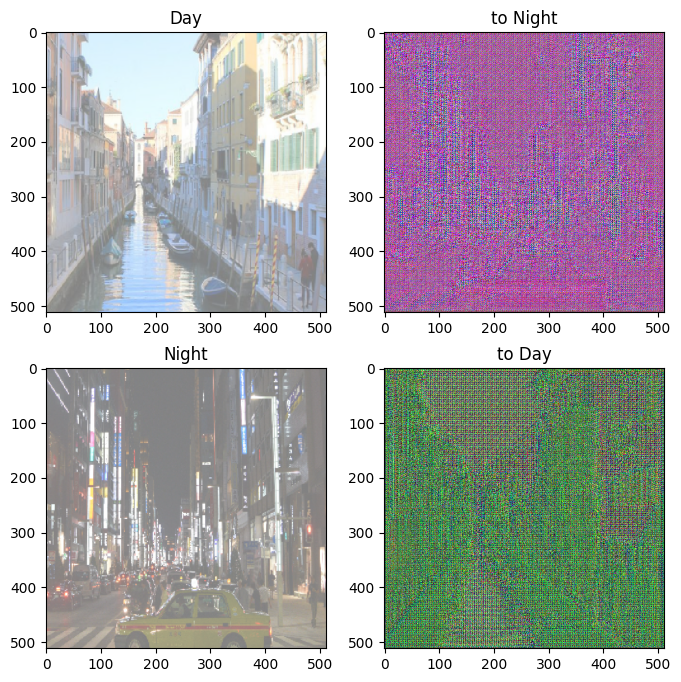

In [ ]:
day_generated = generator_g(sample_day)
night_generated = generator_f(sample_night)
plt.figure(figsize = (8,8))
imgs = [sample_day, night_generated, sample_night, day_generated]
title = ['Day', 'to Night', 'Night', 'to Day']
for i in range(len(imgs)):
  plt.subplot(2, 2, i + 1)
  plt.title(title[i])
  if i%2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * 6 + 0.5)
plt.show()

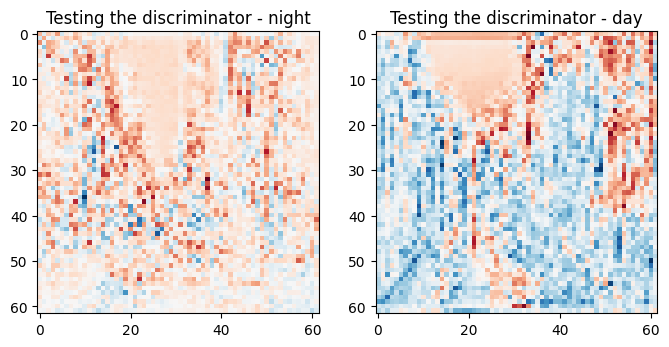

In [ ]:
plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.title('Testing the discriminator - night')
plt.imshow(discriminator_y(sample_night)[0, ..., -1], cmap = 'RdBu_r')

plt.subplot(1, 2, 2)
plt.title('Testing the discriminator - day')
plt.imshow(discriminator_x(sample_day)[0, ..., -1], cmap = 'RdBu_r')

plt.show()

# Loss funstion

In [ ]:
lambda_ = 10 # Define a constant lambda value for scaling losses
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss(tf.ones_like(real), real) # Calculate the loss for the real images, aiming for real labels (1)
  generated_loss = loss(tf.zeros_like(generated), generated) # Calculate the loss for the generated (fake) images, aiming for fake labels (0)
  d_total_loss = real_loss + generated_loss # Combine the real and generated losses to get the total discriminator loss
  return d_total_loss

In [ ]:
def generator_loss(generated):
  return loss(tf.ones_like(generated), generated) # The generator aims to fool the discriminator into classifying generated images as real (1)

In [ ]:
def cycle_loss(real_img, cycled_img):
  loss1 = tf.reduce_mean(tf.abs(real_img - cycled_img)) # Mean absolute error (MAE) between the real image and the cycled (reconstructed) image
  return lambda_ * loss1 # Scale the cycle loss by the lambda constant to control its importance

In [ ]:
def identity_loss(real_img, equal_img):
  loss = tf.reduce_mean(tf.abs(real_img - equal_img)) # Mean absolute error (MAE) between the real image and the identity-preserved image
  return lambda_ * 0.5 * loss

# Optimizers

In [ ]:
lr = 0.0002
beta1, beta2 = 0.5, 0.999

In [ ]:
optimizer_generator_g = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)
optimizer_generator_f = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)

optimizer_discriminator_x = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)
optimizer_discriminator_y = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)

In [ ]:
checkpoint_dir = "./checkpoints/train"
checkpoint = tf.train.Checkpoint(generator_g = generator_g,
                                 generator_f = generator_f,
                                 discriminator_x = discriminator_x,
                                 discriminator_y = discriminator_y,
                                 generator_g_optimizer=optimizer_generator_g,
                                 generator_f_optimizer = optimizer_generator_f,
                                 discriminator_x_optimizer = optimizer_discriminator_x,
                                 discriminator_y_optimizer = optimizer_discriminator_y)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep = 5)
if checkpoint_manager.latest_checkpoint:
  checkpoint.restore(checkpoint_manager.latest_checkpoint)
  print('Latest checkpoint restored!')

# Training

In [ ]:
def generate_images(model, test_input):
  #Generates and displays images using the given model and input.
  if test_input.shape != (1, 512, 512, 3): #check if the input is already in batch format
      test_input = tf.expand_dims(test_input, axis=0)
  generated = model(test_input) # Pass the input image to the model for transformation.
  plt.figure(figsize = (8,6))
  list_imgs = [test_input[0], generated[0]]
  title = ['Original', 'Output (generated)']
  for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(title[i])
    plt.imshow(list_imgs[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def training_step(real_x, real_y):
  #Performs a single training step for the CycleGAN.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G: X -> Y
    # Generator F: Y -> X

    fake_y = generator_g(real_x, training = True) # Generator G generates fake Y from real X
    cycled_x = generator_f(fake_y, training = True) # Generator F generates cycled X from fake Y

    fake_x = generator_f(real_y, training = True)  # Generator F generates fake X from real Y
    cycled_y = generator_g(fake_x, training = True) # Generator G generates cycled Y from fake X

    # Identity mapping: G and F should ideally map real X and real Y to themselves
    equal_x = generator_f(real_x, training = True)
    equal_y = generator_g(real_y, training = True)

    # Discriminator outputs: check if generated images are real or fake
    discriminator_real_x = discriminator_x(real_x, training = True)
    discriminator_fake_x = discriminator_x(fake_x, training = True)
    discriminator_real_y = discriminator_y(real_y, training = True)
    discriminator_fake_y = discriminator_y(fake_y, training = True)

    # Loss calculation
    generator_g_loss = generator_loss(discriminator_fake_y) # Loss for Generator G based on how well it fools Discriminator Y with fake images
    generator_f_loss = generator_loss(discriminator_fake_x) # Loss for Generator F based on how well it fools Discriminator X with fake images
    cycle_loss_total = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)  # Cycle consistency loss: ensure that the generators map images back to their originals
    total_generator_g_loss = generator_g_loss + cycle_loss_total + identity_loss(real_y, equal_y) # Total loss for Generator G
    total_generator_f_loss = generator_f_loss + cycle_loss_total + identity_loss(real_x, equal_x) # Total loss for Generator F
    discriminator_x_loss = discriminator_loss(discriminator_real_x, discriminator_fake_x) # Total loss for Discriminator X
    discriminator_y_loss = discriminator_loss(discriminator_real_y, discriminator_fake_y) # Total loss for Discriminator Y

  # Calculate gradients for all variables (G, F, Discriminators)
  generator_g_gradients = tape.gradient(total_generator_g_loss, generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_generator_f_loss, generator_f.trainable_variables)
  discriminator_x_gradients = tape.gradient(discriminator_x_loss, discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(discriminator_y_loss, discriminator_y.trainable_variables)
  print(total_generator_g_loss)

  # Apply gradients to update the variables using their respective optimizers
  optimizer_generator_g.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
  optimizer_generator_f.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
  optimizer_discriminator_x.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
  optimizer_discriminator_y.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

  # Return the total loss for Generator G as the main feedback for training
  return total_generator_g_loss

In [ ]:
def train(training_A, training_B, generator_g, epochs):
  for epoch in range(epochs):
    start = time.time()

    total_g_loss = 0

    n = 0
    for img_x, img_y in tf.data.Dataset.zip((training_A, training_B)):
      g_loss = training_step(img_x, img_y)
      total_g_loss += g_loss
      if n % 10 == 0:
        print('.', end = '')
      n += 1

    avg_g_loss = total_g_loss / n

    #clear_output(wait = True)
    generate_images(generator_g, sample_day)
    print('Time taken to train epoch {}: {} seconds\n'.format(epoch + 1, time.time() - start))

    print('\nEpoch {}: Generator G Loss: {:.4f}'.format(
        epoch + 1, avg_g_loss.numpy()))


    if (epoch + 1) % 5 == 0:
      checkpoint_dir_saved = checkpoint_manager.save()
      print('Checkpoint saved')

    #generator_g.save_weights('model_cyclegan.weights.h5')
    generator_f.save_weights('model_cyclegan2.weights.h5')

Tensor("add_2:0", shape=(), dtype=float32)
Tensor("add_2:0", shape=(), dtype=float32)
...................

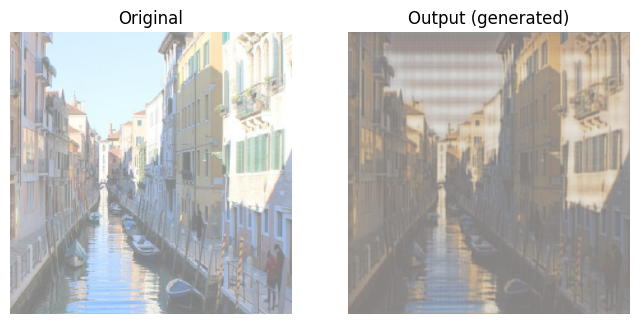

Time taken to train epoch 1: 198.5894742012024 seconds


Epoch 1: Generator G Loss: 3.9130
...................

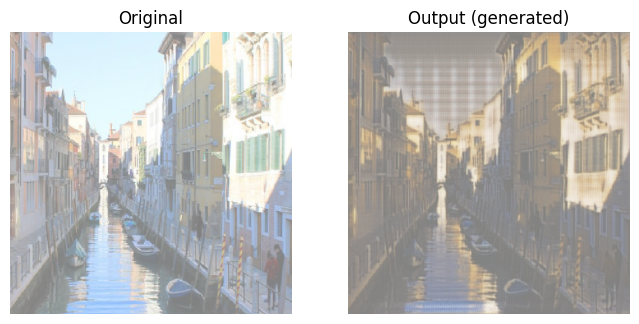

Time taken to train epoch 2: 164.39480328559875 seconds


Epoch 2: Generator G Loss: 3.2550
...................

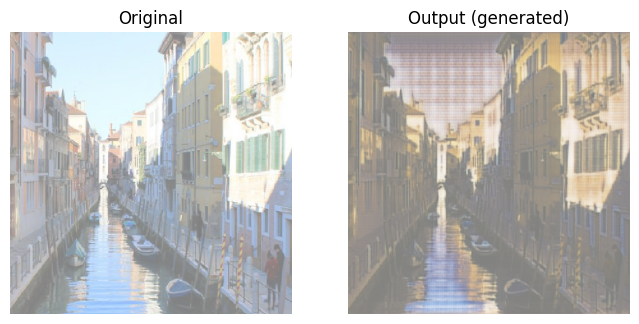

Time taken to train epoch 3: 164.4187970161438 seconds


Epoch 3: Generator G Loss: 3.0438
...................

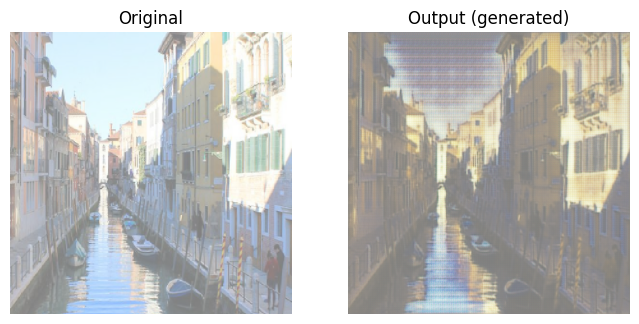

Time taken to train epoch 4: 164.66526818275452 seconds


Epoch 4: Generator G Loss: 2.8596
...................

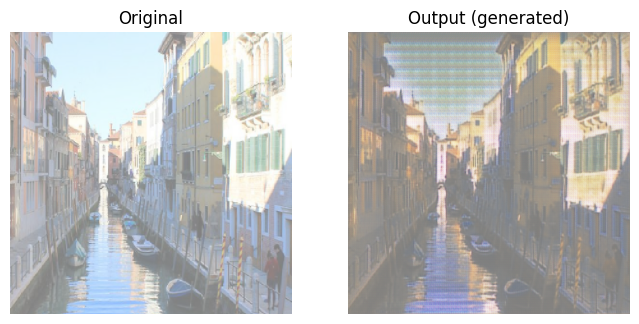

Time taken to train epoch 5: 164.75094199180603 seconds


Epoch 5: Generator G Loss: 2.7659
Checkpoint saved
...................

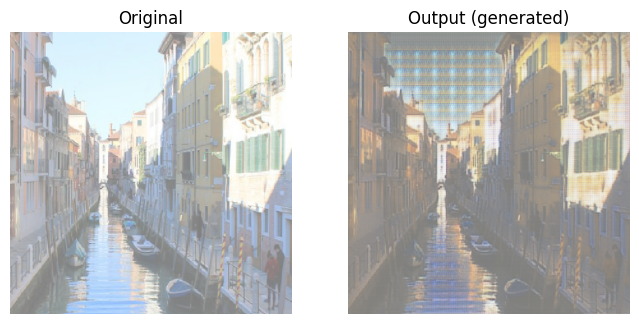

Time taken to train epoch 6: 164.80266451835632 seconds


Epoch 6: Generator G Loss: 2.8184
...................

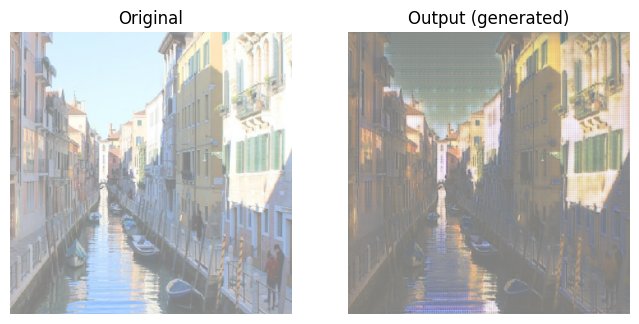

Time taken to train epoch 7: 164.7057819366455 seconds


Epoch 7: Generator G Loss: 2.7777
...................

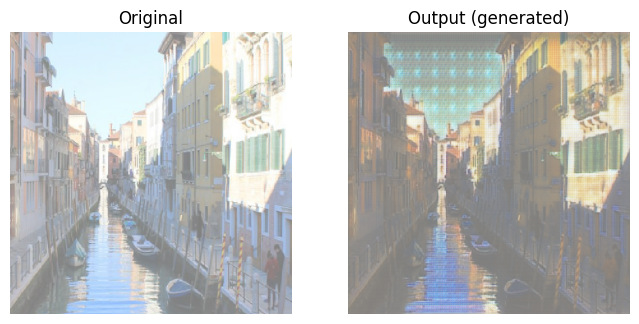

Time taken to train epoch 8: 164.41263842582703 seconds


Epoch 8: Generator G Loss: 2.8095
...................

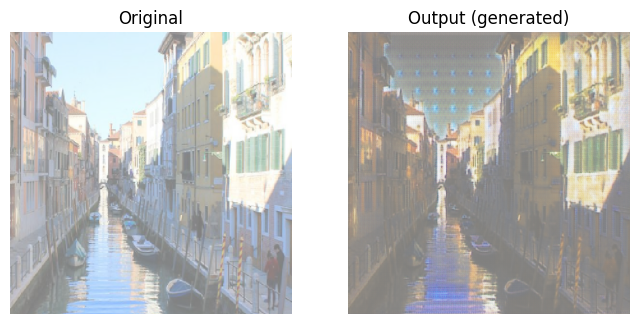

Time taken to train epoch 9: 163.9787425994873 seconds


Epoch 9: Generator G Loss: 2.7652
...................

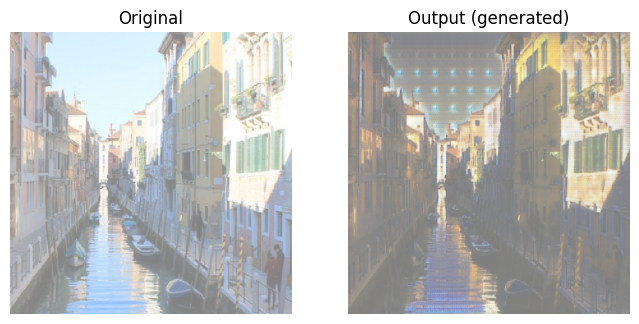

Time taken to train epoch 10: 164.05436325073242 seconds


Epoch 10: Generator G Loss: 2.7686
Checkpoint saved


In [ ]:
train(day_train_dataset, night_train_dataset, generator_g, epochs=10)

In [ ]:
sample_day.shape

TensorShape([1, 512, 512, 3])

In [ ]:
#train(human_train_dataset, simpson_train_dataset, generator_g, epochs=50) #ran 27 more epochs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#generator_g.save('night_generator.h5')

In [ ]:
#generator_g.save_weights('model_cyclegan2.weights.h5') #save the final weights
#generator_f.save_weights('model_cyclegan.weights.h5')

In [ ]:
#generator_g.save_weights('/content/model_cyclegan.weights.h5') #save the final weights
#generator_f.save_weights('/content/model_cyclegan.weights.h5')

In [ ]:
#generator_g.save('/content/drive/MyDrive/Project CycleGan/night_generator.h5')

In [ ]:
#generator_f.save_weights('/content/drive/MyDrive/Project CycleGan/model_cyclegan2.weights.h5')

In [ ]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Model inference

In [ ]:
generator_g.load_weights('model_cyclegan2.weights.h5') #save the weights of the epoch with the best result (manual)
#generator_f.load_weights('model_cyclegan.weights.h5')

In [ ]:
for input in day_train_dataset.take(5):
  generate_images(generator_g, input)

In [ ]:
for input in day_test_dataset.take(5):
  #print(input)
  input = tf.squeeze(input)
  generate_images(generator_g, input)

# Model inference

In [ ]:
generator_g.load_weights('model_cyclegan2.weights.h5') #save the weights of the epoch with the best result (manual)
#generator_f.load_weights('model_cyclegan.weights.h5')

In [ ]:
for input in day_train_dataset.take(5):
  generate_images(generator_g, input)

In [ ]:
for input in day_test_dataset.take(5):
  #print(input)
  input = tf.squeeze(input)
  generate_images(generator_g, input)